NOTE: this wont run properly if run with llama_index versions lower than 11 (becaus of triplet parser function)

In [1]:
from groq import Groq
from llama_index.core import Settings, ServiceContext, StorageContext, SimpleDirectoryReader
from llama_index.llms.groq import Groq as Groq_llamaindex
#from llama_index.llms.ollama import Ollama as Ollama_llamaindex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
#from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import VectorStoreIndex
from llama_index.graph_stores.neo4j import Neo4jGraphStore, Neo4jPropertyGraphStore
from milvus import default_server
from dotenv import load_dotenv
from llama_index.core.indices.property_graph import SchemaLLMPathExtractor, SimpleLLMPathExtractor, ImplicitPathExtractor, DynamicLLMPathExtractor
from llama_index.core import Document

from llama_index.core.node_parser import (
    SentenceSplitter,
    SemanticSplitterNodeParser,
)



load_dotenv()
import json
import os
import numpy as np


# Retrieve API keys and credentials securely
GROQ_API_KEY = os.getenv('GROQ_API_KEY')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
NEO4J_URL = os.getenv('NEO4J_URL', 'bolt://localhost:7687')
NEO4J_DATABASE = os.getenv('NEO4J_DATABASE', 'neo4j')


#client = Groq(api_key = GROQ_API_KEY)

llm = Groq_llamaindex(model="llama3-groq-70b-8192-tool-use-preview",
                       api_key=GROQ_API_KEY, #using data uploader for now
                       temperature=0)

#llm = Ollama_llamaindex(model='mistral:instruct', temperature=0)

Settings.llm = llm
Settings.embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5"
)

StorageContext.llm = llm
ServiceContext.llm = llm

/Users/felipenavarro/Documents/Auckland/nzta/nzta_experiment/NZTA-GraphRAG-Experiment/nzta_experiment_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
username = NEO4J_USERNAME
password =  NEO4J_PASSWORD
url = NEO4J_URL
database = NEO4J_DATABASE



In [3]:

property_graph_store = Neo4jPropertyGraphStore(
    username=username,
    password=password,
    url=url,
    database=database,
    refresh_schema=False,
)
storage_context = StorageContext.from_defaults(property_graph_store=property_graph_store)



Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


In [4]:

with open("transport_data/sp_cot/newzealand transport agency and newzealand transport related topics (road, projects, safety, vehicles, personel, organization, etc)_100.json", 'r') as file:
    data = json.load(file)



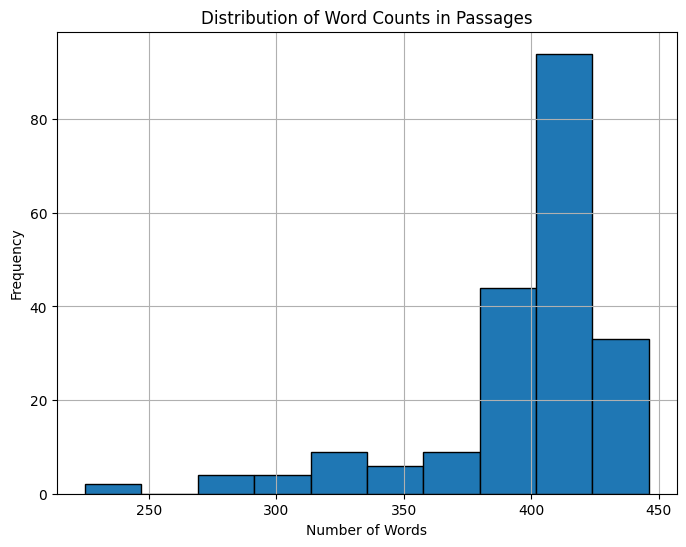

In [5]:
import matplotlib.pyplot as plt


# Extract passages from both 'first_hops' and 'second_hops'
passages = []

# Retrieve passages from first_hops
for entity, info in data.get('first_hops', {}).items():
    passages.append(info['passage'])

# Retrieve passages from second_hops
for entity, info in data.get('second_hops', {}).items():
    passages.append(info['passage'])

# Count the number of words in each passage
word_counts = [len(passage.split()) for passage in passages]

# Plotting the histogram of word counts
plt.figure(figsize=(8, 6))
plt.hist(word_counts, bins=10, edgecolor='black')
plt.title('Distribution of Word Counts in Passages')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [6]:
len(passages)

205

In [7]:
import os
import csv
import re
import signal
import sys
import time
from llama_index.core import PropertyGraphIndex
from llama_index.core.indices.property_graph import SimpleLLMPathExtractor
from llama_index.core import SimpleDirectoryReader
import nest_asyncio

nest_asyncio.apply()

# Constants
PROCESSED_FILE = 'processed_passages.csv'
TEMP_DIR = 'temp_passages'

# Initialize processed pairs set
processed_pairs = set()

# Sanitize filenames by replacing non-alphanumeric characters with underscores
sanitize_filename = lambda name: re.sub(r'[^a-zA-Z0-9_\-]', '_', name)

# Generate a unique filename with optional integer suffix
def generate_unique_filename(hop_type, term, directory, extension='txt'):
    base_name = f"{sanitize_filename(hop_type)}_{sanitize_filename(term)}"
    file_path = os.path.join(directory, f"{base_name}.{extension}")
    counter = 1
    while os.path.exists(file_path):
        file_path = os.path.join(directory, f"{base_name}_{counter}.{extension}")
        counter += 1
    return file_path

# Load processed pairs from CSV
def load_processed_pairs(file_path):
    if os.path.exists(file_path):
        try:
            with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
                reader = csv.reader(csvfile)
                processed_pairs.update(tuple(row[:2]) for row in reader if len(row) >= 2)
            print(f"Loaded {len(processed_pairs)} processed pairs from '{file_path}'.")
        except Exception as e:
            print(f"Error loading processed pairs: {e}")
    else:
        print(f"No existing processed file found at '{file_path}'. Starting fresh.")

# Append a processed pair to CSV
def append_processed_pair(writer, hop_type, term):
    try:
        writer.writerow([hop_type, term])
        writer.flush()
        os.fsync(writer.fileno())
        processed_pairs.add((hop_type, term))
        print(f"Recorded pair: Hop Type='{hop_type}', Term='{term}'")
    except Exception as e:
        print(f"Error recording pair ({hop_type}, {term}): {e}")

# Signal handler for graceful shutdown
def signal_handler(sig, frame):
    print('Interrupt received. Exiting...')
    sys.exit(0)

signal.signal(signal.SIGINT, signal_handler)
signal.signal(signal.SIGTERM, signal_handler)

# Ensure temp directory exists
os.makedirs(TEMP_DIR, exist_ok=True)

# Load already processed pairs
load_processed_pairs(PROCESSED_FILE)

# Open the processed file in append mode
try:
    processed_file = open(PROCESSED_FILE, 'a', newline='', encoding='utf-8', buffering=1)
    csv_writer = csv.writer(processed_file)
except Exception as e:
    print(f"Failed to open '{PROCESSED_FILE}' for appending: {e}")
    sys.exit(1)

# Helper function to process and save passages
def process_passages(hop_type, data):
    for term, info in data.items():
        if (hop_type, term) in processed_pairs:
            print(f"Skipping already processed pair: Hop Type={hop_type}, Term={term}")
            continue

        passage = info.get('passage')
        if not passage:
            print(f"No passage found for term '{term}'. Skipping.")
            continue

        # Ensure only one file in temp directory
        for existing_file in os.listdir(TEMP_DIR):
            existing_path = os.path.join(TEMP_DIR, existing_file)
            os.remove(existing_path)
            print(f"Removed existing file '{existing_path}' from temp directory.")

        # Generate unique filename and save passage
        temp_file_path = generate_unique_filename(hop_type, term, TEMP_DIR)
        try:
            with open(temp_file_path, 'w', encoding='utf-8') as file:
                file.write(passage)
            print(f"Saved passage for term '{term}' to '{temp_file_path}'.")
        except Exception as e:
            print(f"Error writing passage for term '{term}' to '{temp_file_path}': {e}")
            continue

        # Process the passage
        try:
            graph_documents = SimpleDirectoryReader(TEMP_DIR).load_data()
            graph_index = PropertyGraphIndex.from_documents(
                graph_documents,
                property_graph_store=property_graph_store,  # Ensure these are defined
                storage_context=storage_context,            # Ensure these are defined
                kg_extractors=[SimpleLLMPathExtractor(llm=llm)],  # Ensure llm is defined
                embed_kg_nodes=True,
                show_progress=True
            )
            print(f"Processed term '{term}' with hop type '{hop_type}'.")
            time.sleep(20)  # Pause as required
        except Exception as e:
            print(f"Error processing term '{term}': {e}")
            continue
        finally:
            # Remove the temp file after processing
            try:
                os.remove(temp_file_path)
                print(f"Removed temp file '{temp_file_path}'.")
            except Exception as e:
                print(f"Error removing temp file '{temp_file_path}': {e}")

        # Record the processed pair
        append_processed_pair(csv_writer, hop_type, term)



# Process passages for each hop type
process_passages('first_hops', data.get('first_hops', {}))
process_passages('second_hops', data.get('second_hops', {}))

# Close the processed file
try:
    processed_file.close()
    print(f"All processed pairs have been recorded to '{PROCESSED_FILE}'.")
except Exception as e:
    print(f"Error closing '{PROCESSED_FILE}': {e}")


No existing processed file found at 'processed_passages.csv'. Starting fresh.
Saved passage for term 'Transport Projects' to 'temp_passages/first_hops_Transport_Projects.txt'.


Generating embeddings: 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


Processed term 'Transport Projects' with hop type 'first_hops'.
Removed temp file 'temp_passages/first_hops_Transport_Projects.txt'.
Error recording pair (first_hops, Transport Projects): '_csv.writer' object has no attribute 'flush'
Saved passage for term 'Road Safety Initiatives' to 'temp_passages/first_hops_Road_Safety_Initiatives.txt'.


Generating embeddings: 100%|██████████| 6/6 [00:00<00:00,  7.44it/s]
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


Processed term 'Road Safety Initiatives' with hop type 'first_hops'.
Removed temp file 'temp_passages/first_hops_Road_Safety_Initiatives.txt'.
Error recording pair (first_hops, Road Safety Initiatives): '_csv.writer' object has no attribute 'flush'
Saved passage for term 'Public Transport Development' to 'temp_passages/first_hops_Public_Transport_Development.txt'.


Extracting paths from text:   0%|          | 0/1 [00:00<?, ?it/s]

Interrupt received. Exiting...
Removed temp file 'temp_passages/first_hops_Public_Transport_Development.txt'.


SystemExit: 0

/Users/felipenavarro/Documents/Auckland/nzta/nzta_experiment/NZTA-GraphRAG-Experiment/nzta_experiment_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
